In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tqdm import tqdm

In [3]:
# Load firm-level data
firm_df = pd.read_csv("D:/Projects/Portfolio/Portfolio_Investment_Strategy/data/raw/mma_sample_v2.csv", parse_dates=["date"])

In [5]:
# Load 147 factor variables
factor_list = pd.read_csv("D:/Projects/Portfolio/Portfolio_Investment_Strategy/data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

In [6]:
# Drop rows with missing earnings info
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])

In [7]:
# Construct surprise and shift as t+1 label
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"])

In [8]:
# Normalize features to [-1, 1] per month cross-section
all_dates = model_df["date"].unique()
normalized_list = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized_list.append(temp)
normalized_df = pd.concat(normalized_list).reset_index(drop=True)

In [10]:
# Define function to run one expanding window round
def run_one_round(train, val, test, factor_vars):
    scaler = StandardScaler()
    scaler.fit(train[factor_vars])
    X_train = scaler.transform(train[factor_vars])
    X_val = scaler.transform(val[factor_vars])
    X_test = scaler.transform(test[factor_vars])
    y_train = train["target_surprise_t+1"].values
    y_val = val["target_surprise_t+1"].values
    y_test = test["target_surprise_t+1"].values

    # Lasso tuning on validation
    lambdas = np.arange(-4, 2.1, 0.2)
    val_mse = []
    for i in lambdas:
        lasso = Lasso(alpha=10**i, max_iter=100000)
        lasso.fit(X_train, y_train)
        val_pred = lasso.predict(X_val)
        val_mse.append(mean_squared_error(y_val, val_pred))

    best_lambda = lambdas[np.argmin(val_mse)]
    final_model = Lasso(alpha=10**best_lambda, max_iter=100000)
    final_model.fit(X_train, y_train)
    y_pred_test = final_model.predict(X_test)

    # Save predictions and calculate R^2
    result = test[["date", "permno"]].copy()
    result["pred_surprise"] = y_pred_test
    r2 = r2_score(y_test, y_pred_test)
    return result, r2

In [16]:
# Prepare expanding rounds
start_date = pd.to_datetime("2000-01-01")
test_limit = pd.to_datetime("2024-01-01")
cutoffs = []
counter = 0

while (start_date + pd.DateOffset(years=11 + counter)) <= test_limit:
    train_start = start_date
    train_end = start_date + pd.DateOffset(years=8 + counter)
    val_end = start_date + pd.DateOffset(years=10 + counter)
    test_end = start_date + pd.DateOffset(years=11 + counter)
    cutoffs.append((train_start, train_end, val_end, test_end))
    counter += 1

# Now run using tqdm
print("Starting expanding window prediction...\n")
results = []
r2_list = []
start_time = datetime.now()

for i, (train_start, train_end, val_end, test_end) in enumerate(tqdm(cutoffs, desc="Expanding Rounds")):
    train = normalized_df[(normalized_df["date"] >= train_start) & (normalized_df["date"] < train_end)]
    val = normalized_df[(normalized_df["date"] >= train_end) & (normalized_df["date"] < val_end)]
    test = normalized_df[(normalized_df["date"] >= val_end) & (normalized_df["date"] < test_end)]

    pred, r2 = run_one_round(train, val, test, factor_vars)
    results.append(pred)
    r2_list.append(r2)
    print(f"[Round {i+1}] Test Year: {test_end.year}, R^2: {r2:.4f}")

Starting expanding window prediction...



Expanding Rounds:   0%|                                                                         | 0/14 [06:24<?, ?it/s]

KeyboardInterrupt



In [18]:
# Debug version: Run only first expanding window round for Lasso surprise prediction

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import time

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"])

# Normalize features per month to [-1, 1]
print("Normalizing monthly features...", flush=True)
start_norm = time.time()
all_dates = model_df["date"].unique()
normalized_list = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized_list.append(temp)
normalized_df = pd.concat(normalized_list).reset_index(drop=True)
print(f"Normalization completed in {time.time() - start_norm:.2f} seconds\n")

# First expanding window round only
train = normalized_df[(normalized_df["date"] >= "2000-01-01") & (normalized_df["date"] < "2009-01-01")]
val = normalized_df[(normalized_df["date"] >= "2009-01-01") & (normalized_df["date"] < "2011-01-01")]
test = normalized_df[(normalized_df["date"] >= "2011-01-01") & (normalized_df["date"] < "2012-01-01")]

print(f"Train size: {train.shape}, Val size: {val.shape}, Test size: {test.shape}\n")

# Scaling
scaler = StandardScaler()
scaler.fit(train[factor_vars])
X_train = scaler.transform(train[factor_vars])
X_val = scaler.transform(val[factor_vars])
X_test = scaler.transform(test[factor_vars])
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Mini grid tuning (4 lambdas)
lambdas = [-5, -4, -3, -2, -1]
val_mse = []
print("Lasso tuning...")
for i in lambdas:
    t0 = time.time()
    lasso = Lasso(alpha=10**i, max_iter=100000)
    lasso.fit(X_train, y_train)
    y_val_pred = lasso.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    val_mse.append(mse)
    print(f"  Lambda=1e{i:+}: MSE={mse:.4f} (Time: {time.time() - t0:.2f}s)")

best_lambda = lambdas[np.argmin(val_mse)]
print(f"\nBest lambda: 1e{best_lambda:+}")
final_model = Lasso(alpha=10**best_lambda, max_iter=100000)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

r2 = r2_score(y_test, y_test_pred)
print(f"R^2 on 2011 test set: {r2:.4f}")

# Save preview
output = test[["date", "permno"]].copy()
output["pred_surprise"] = y_test_pred
print("\nSample predictions:")
print(output.head())

Normalizing monthly features...
Normalization completed in 42.86 seconds

Train size: (101924, 167), Val size: (20890, 167), Test size: (10349, 167)

Lasso tuning...
  Lambda=1e-5: MSE=108.2684 (Time: 139.75s)
  Lambda=1e-4: MSE=108.2521 (Time: 41.29s)
  Lambda=1e-3: MSE=108.0628 (Time: 34.52s)
  Lambda=1e-2: MSE=106.4949 (Time: 19.61s)
  Lambda=1e-1: MSE=102.7912 (Time: 1.07s)

Best lambda: 1e-1
R^2 on 2011 test set: -0.0099

Sample predictions:
             date  permno  pred_surprise
151658 2011-01-31   10104       1.386357
151659 2011-01-31   10107       1.190080
151660 2011-01-31   10138      -0.453515
151661 2011-01-31   10145       0.608870
151662 2011-01-31   10147       0.973660


In [19]:
# Ridge Debug version: Run only first expanding window round

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import time

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"])

# Normalize features per month to [-1, 1]
print("Normalizing monthly features...", flush=True)
start_norm = time.time()
all_dates = model_df["date"].unique()
normalized_list = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized_list.append(temp)
normalized_df = pd.concat(normalized_list).reset_index(drop=True)
print(f"Normalization completed in {time.time() - start_norm:.2f} seconds\n")

# First expanding window round only
train = normalized_df[(normalized_df["date"] >= "2000-01-01") & (normalized_df["date"] < "2009-01-01")]
val = normalized_df[(normalized_df["date"] >= "2009-01-01") & (normalized_df["date"] < "2011-01-01")]
test = normalized_df[(normalized_df["date"] >= "2011-01-01") & (normalized_df["date"] < "2012-01-01")]

print(f"Train size: {train.shape}, Val size: {val.shape}, Test size: {test.shape}\n")

# Scaling
scaler = StandardScaler()
scaler.fit(train[factor_vars])
X_train = scaler.transform(train[factor_vars])
X_val = scaler.transform(val[factor_vars])
X_test = scaler.transform(test[factor_vars])
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Ridge model with fixed alpha
print("Fitting Ridge model (alpha=1.0)...")
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R^2 on 2011 test set: {r2:.4f}")

# Save preview
output = test[["date", "permno"]].copy()
output["pred_surprise"] = y_pred
print("\nSample predictions:")
print(output.head())

Normalizing monthly features...
Normalization completed in 43.90 seconds

Train size: (101924, 167), Val size: (20890, 167), Test size: (10349, 167)

Fitting Ridge model (alpha=1.0)...
R^2 on 2011 test set: -0.0516

Sample predictions:
             date  permno  pred_surprise
151658 2011-01-31   10104       3.985236
151659 2011-01-31   10107       1.648463
151660 2011-01-31   10138      -2.376594
151661 2011-01-31   10145       0.475523
151662 2011-01-31   10147       1.290610


Normalizing monthly features...
Normalization completed in 39.48 seconds

Train size: (101924, 167), Val size: (20890, 167), Test size: (10349, 167)

Fitting LightGBM model...


C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37015
[LightGBM] [Info] Number of data points in the train set: 101924, number of used features: 147
[LightGBM] [Info] Start training from score 0.002366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


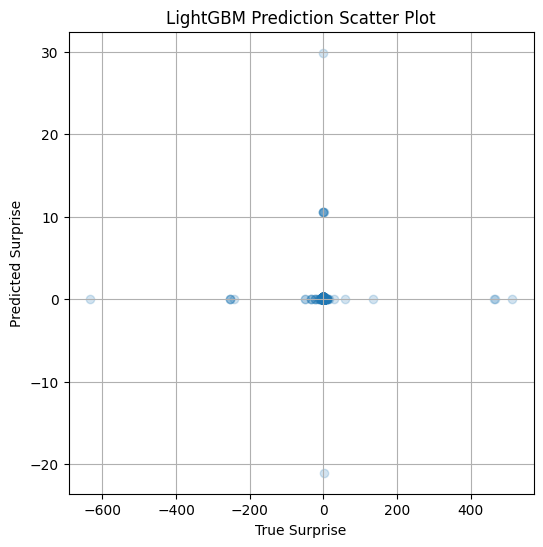

In [22]:
# LightGBM Debug version: Run only first expanding window round

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from datetime import datetime
import time
import matplotlib.pyplot as plt

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"])

# Normalize features per month to [-1, 1]
print("Normalizing monthly features...", flush=True)
start_norm = time.time()
all_dates = model_df["date"].unique()
normalized_list = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized_list.append(temp)
normalized_df = pd.concat(normalized_list).reset_index(drop=True)
print(f"Normalization completed in {time.time() - start_norm:.2f} seconds\n")

# First expanding window round only
train = normalized_df[(normalized_df["date"] >= "2000-01-01") & (normalized_df["date"] < "2009-01-01")]
val = normalized_df[(normalized_df["date"] >= "2009-01-01") & (normalized_df["date"] < "2011-01-01")]
test = normalized_df[(normalized_df["date"] >= "2011-01-01") & (normalized_df["date"] < "2012-01-01")]

print(f"Train size: {train.shape}, Val size: {val.shape}, Test size: {test.shape}\n")

# Prepare inputs
X_train = train[factor_vars].values
X_val = val[factor_vars].values
X_test = test[factor_vars].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Fit LightGBM model
print("Fitting LightGBM model...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(20)
    ]
)

# Predict and evaluate
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nR^2 on 2011 test set: {r2:.4f}")

# Save preview
output = test[["date", "permno"]].copy()
output["pred_surprise"] = y_pred
print("\nSample predictions:")
print(output.head())

# Optional: plot prediction vs truth
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("True Surprise")
plt.ylabel("Predicted Surprise")
plt.title("LightGBM Prediction Scatter Plot")
plt.grid(True)
plt.show()

<Axes: >

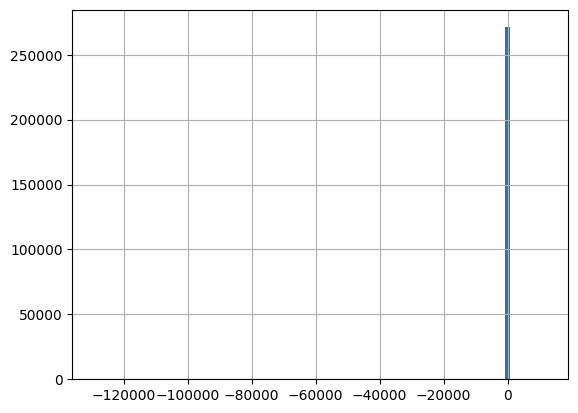

In [23]:
import matplotlib.pyplot as plt
firm_df["earning_surprise"].hist(bins=100)

In [24]:
q1 = model_df["earning_surprise"].quantile(0.25)
q3 = model_df["earning_surprise"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

# Apply Winsorization（clip）
model_df["earning_surprise_winsor"] = model_df["earning_surprise"].clip(lower=lower_bound, upper=upper_bound)

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_17204\667909954.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["earning_surprise_winsor"] = model_df["earning_surprise"].clip(lower=lower_bound, upper=upper_bound)


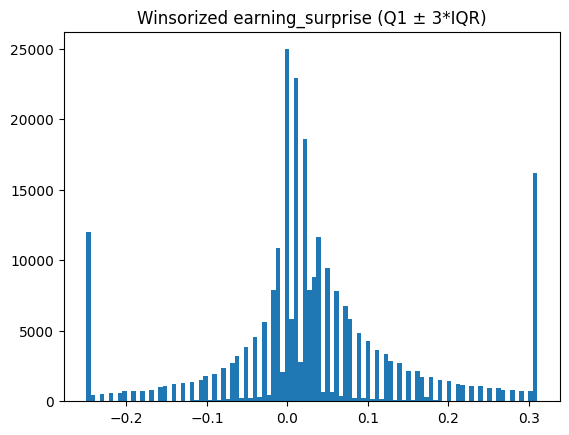

In [25]:
import matplotlib.pyplot as plt

plt.hist(model_df["earning_surprise_winsor"], bins=100)
plt.title("Winsorized earning_surprise (Q1 ± 3*IQR)")
plt.show()

Normalizing features...
Training LightGBM on full data...


C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37015
[LightGBM] [Info] Number of data points in the train set: 101924, number of used features: 147
[LightGBM] [Info] Start training from score 0.008057
Training until validation scores don't improve for 20 rounds
[20]	valid_0's l2: 0.051689
Early stopping, best iteration is:
[9]	valid_0's l2: 0.0510472

[Full Test R^2]: -0.0089

Segment-wise R^2:
  neg: R^2 = -0.8121 (1516 samples)
  neutral: R^2 = -0.6929 (5885 samples)
  pos: R^2 = -0.6324 (2948 samples)


C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_17204\2939203981.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["y_true"] = y_test
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_17204\2939203981.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["y_pred"] = y_pred


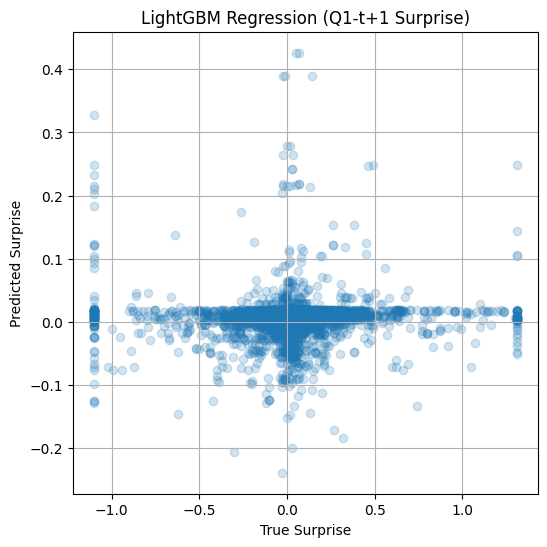

In [26]:
# LightGBM Segmented Regression: Three-Bucket + Full Regression Pipeline

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

# Compute earning surprise and shift t+1
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(lower=firm_df["earning_surprise"].quantile(0.01),
                                                                 upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Define 3-segment buckets for analysis
bins = [-np.inf, -0.05, 0.05, np.inf]
labels = ["neg", "neutral", "pos"]
model_df["surprise_bucket"] = pd.cut(model_df["target_surprise_t+1"], bins=bins, labels=labels)

# Normalize factor vars per month using [-1, 1] rank
print("Normalizing features...", flush=True)
all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# Define one expanding window only
train = model_df[(model_df["date"] >= "2000-01-01") & (model_df["date"] < "2009-01-01")]
val = model_df[(model_df["date"] >= "2009-01-01") & (model_df["date"] < "2011-01-01")]
test = model_df[(model_df["date"] >= "2011-01-01") & (model_df["date"] < "2012-01-01")]

X_train = train[factor_vars].values
X_val = val[factor_vars].values
X_test = test[factor_vars].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Train LightGBM regression
print("Training LightGBM on full data...")
model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(20)]
)

# Predict and compute overall R^2
y_pred = model.predict(X_test)
full_r2 = r2_score(y_test, y_pred)
print(f"\n[Full Test R^2]: {full_r2:.4f}")

# Compute segmented R^2
test["y_true"] = y_test
test["y_pred"] = y_pred

print("\nSegment-wise R^2:")
for label in labels:
    seg = test[test["surprise_bucket"] == label]
    if len(seg) >= 20:
        r2 = r2_score(seg["y_true"], seg["y_pred"])
        print(f"  {label}: R^2 = {r2:.4f} ({len(seg)} samples)")
    else:
        print(f"  {label}: Too few samples ({len(seg)})")

# Plot prediction vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("True Surprise")
plt.ylabel("Predicted Surprise")
plt.title("LightGBM Regression (Q1-t+1 Surprise)")
plt.grid(True)
plt.show()

Normalizing features...
Training Lasso (alpha=0.001)...

Test R^2: 0.0096

Top Non-zero Lasso Coefficients:
seas_1_1na           0.010346
saleq_gr1            0.007966
betabab_1260d       -0.007942
ret_1_0              0.007178
div12m_me           -0.006388
be_me               -0.006241
debt_me             -0.005996
ni_me                0.005898
ebit_bev            -0.005654
turnover_var_126d   -0.005626
nfna_gr1a           -0.005542
o_score              0.005070
ebitda_mev           0.004752
ret_12_1             0.004647
ret_6_1              0.004205
z_score             -0.003762
ni_inc8q             0.003694
tangibility          0.003671
niq_be_chg1          0.003641
taccruals_at         0.003484
dtype: float64


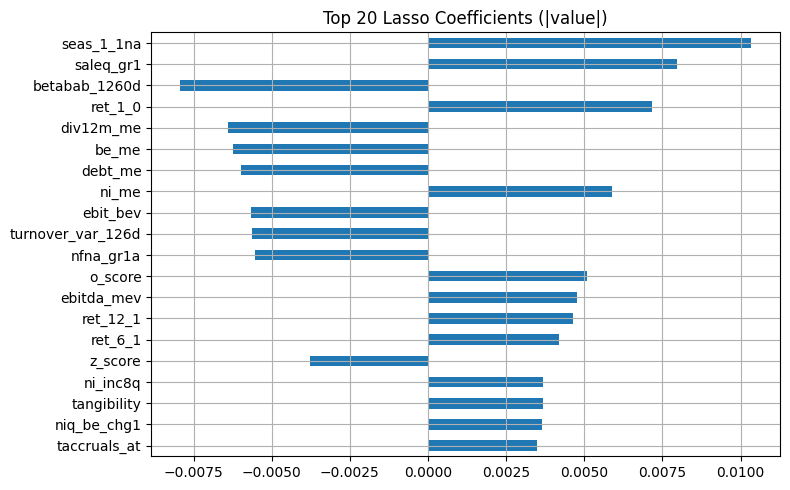

In [31]:
# Lasso Regression to Identify Predictive Terms for Earning Surprise

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(lower=firm_df["earning_surprise"].quantile(0.01),
                                                                 upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize factor vars per month using [-1, 1] rank
print("Normalizing features...", flush=True)
all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# One expanding window only
train = model_df[(model_df["date"] >= "2000-01-01") & (model_df["date"] < "2009-01-01")]
val = model_df[(model_df["date"] >= "2009-01-01") & (model_df["date"] < "2011-01-01")]
test = model_df[(model_df["date"] >= "2011-01-01") & (model_df["date"] < "2012-01-01")]

X_train = train[factor_vars].values
X_val = val[factor_vars].values
X_test = test[factor_vars].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Scale features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Fit Lasso with selected alpha
print("Training Lasso (alpha=0.001)...")
lasso = Lasso(alpha=0.001, max_iter=100000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"\nTest R^2: {r2:.4f}")

# Extract non-zero coefficients
coef = pd.Series(lasso.coef_, index=factor_vars)
nonzero_coef = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print("\nTop Non-zero Lasso Coefficients:")
print(nonzero_coef.head(20))

# Plot top coefficients
plt.figure(figsize=(8, 5))
nonzero_coef.head(20).plot(kind="barh")
plt.title("Top 20 Lasso Coefficients (|value|)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
pd.Series(selected_features).to_csv("../results/lasso_selected_features.csv", index=False)
print("\nSaved top 20 Lasso features to: ../results/lasso_selected_features.csv")


Saved top 20 Lasso features to: ../results/lasso_selected_features.csv


Normalizing features...
Running LassoCV to auto-tune alpha...

Best alpha: 0.00379
Test R^2: 0.0067

Top LassoCV Features:
seas_1_1na           0.011277
saleq_gr1            0.004882
ret_12_1             0.004441
prc_highprc_252d     0.004182
div12m_me           -0.003931
niq_be_chg1          0.002864
betabab_1260d       -0.002735
ret_1_0              0.002574
ret_6_1              0.002541
turnover_var_126d   -0.002430
prc                  0.002081
tangibility          0.001941
niq_be               0.001877
dgp_dsale            0.001704
ni_inc8q             0.001282
ni_ivol              0.001209
beta_dimson_21d     -0.000915
qmj_growth           0.000437
cop_atl1             0.000353
dtype: float64


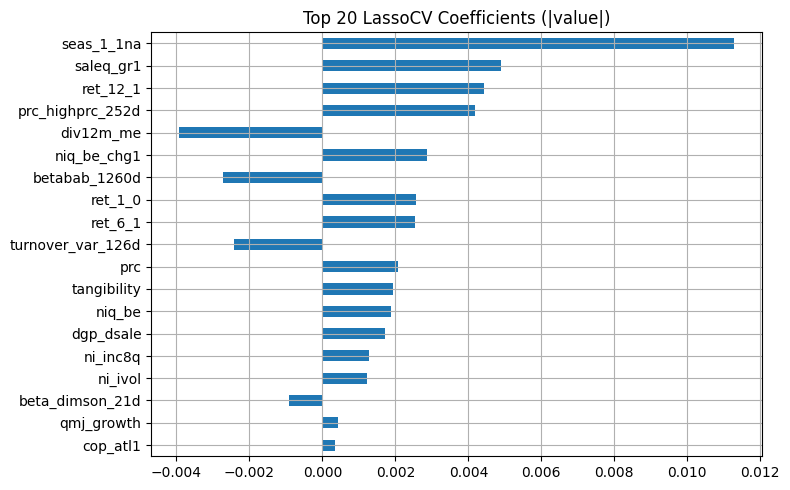

In [33]:
# Step ①: LassoCV auto tuning + top feature selection

import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

# Preprocess earning surprise
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize factor vars per month using [-1, 1] rank
print("Normalizing features...", flush=True)
all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# First expanding window only
train = model_df[(model_df["date"] >= "2000-01-01") & (model_df["date"] < "2009-01-01")]
val = model_df[(model_df["date"] >= "2009-01-01") & (model_df["date"] < "2011-01-01")]
test = model_df[(model_df["date"] >= "2011-01-01") & (model_df["date"] < "2012-01-01")]

X_train = train[factor_vars].values
X_val = val[factor_vars].values
X_test = test[factor_vars].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Standardize
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Run LassoCV
print("Running LassoCV to auto-tune alpha...")
lasso_cv = LassoCV(alphas=10**np.linspace(-4, -1, 20), cv=5, max_iter=100000, random_state=42)
lasso_cv.fit(X_train_std, y_train)

# Evaluate on test
y_pred = lasso_cv.predict(X_test_std)
r2 = r2_score(y_test, y_pred)
print(f"\nBest alpha: {lasso_cv.alpha_:.5f}")
print(f"Test R^2: {r2:.4f}")

# Get top features
coef = pd.Series(lasso_cv.coef_, index=factor_vars)
nonzero = coef[coef != 0].sort_values(key=np.abs, ascending=False)
print("\nTop LassoCV Features:")
print(nonzero.head(20))

# Plot
plt.figure(figsize=(8, 5))
nonzero.head(20).plot(kind="barh")
plt.title("Top 20 LassoCV Coefficients (|value|)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save feature list
selected_features = list(nonzero.head(20).index)


In [34]:
pd.Series(selected_features).to_csv("../results/lasso_cv_selected_features.csv", index=False)
print("\nSaved top 20 Lasso features to: ../results/lasso_cv_selected_features.csv")


Saved top 20 Lasso features to: ../results/lasso_cv_selected_features.csv


Normalizing features...
Training Ridge (alpha=1.0)...

Test R^2: 0.0035

Top 20 Ridge Features:
gp_at                0.025152
gp_atl1              0.024544
be_me                0.022688
at_turnover          0.022399
turnover_var_126d    0.020874
nfna_gr1a            0.020531
cop_atl1             0.018961
taccruals_at         0.018758
dolvol_var_126d      0.017835
sale_me              0.015799
ivol_ff3_21d         0.015051
opex_at              0.014923
o_score              0.014750
debt_me              0.013433
qmj_prof             0.013233
ni_me                0.013033
market_equity        0.012915
cop_at               0.012761
saleq_gr1            0.012431
ocf_at               0.012332
dtype: float64


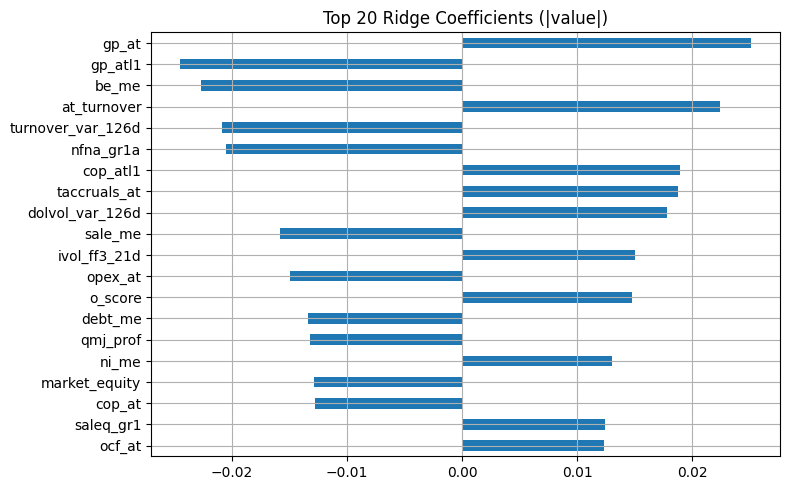

In [29]:
# Ridge Regression: Select top 20 features by coefficient magnitude

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

# Preprocess earning surprise
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize per month [-1, 1]
print("Normalizing features...", flush=True)
all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in factor_vars:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# Expanding window: 1st round
train = model_df[(model_df["date"] >= "2000-01-01") & (model_df["date"] < "2009-01-01")]
val = model_df[(model_df["date"] >= "2009-01-01") & (model_df["date"] < "2011-01-01")]
test = model_df[(model_df["date"] >= "2011-01-01") & (model_df["date"] < "2012-01-01")]

X_train = train[factor_vars].values
X_val = val[factor_vars].values
X_test = test[factor_vars].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Standardize
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Train Ridge
print("Training Ridge (alpha=1.0)...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_std, y_train)
y_pred = ridge.predict(X_test_std)

r2 = r2_score(y_test, y_pred)
print(f"\nTest R^2: {r2:.4f}")

# Rank features by absolute weight
coef = pd.Series(ridge.coef_, index=factor_vars)
top_coef = coef.abs().sort_values(ascending=False).head(20)
print("\nTop 20 Ridge Features:")
print(top_coef)

# Plot
plt.figure(figsize=(8, 5))
coef[top_coef.index].plot(kind="barh")
plt.title("Top 20 Ridge Coefficients (|value|)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save
pd.Series(top_coef.index).to_csv("../results/ridge_selected_features.csv", index=False)
print("\nSaved top 20 Ridge features to: ../results/ridge_selected_features.csv")

Using 19 features from Lasso union

Normalizing features...
Lasso R^2: 0.0055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4607
[LightGBM] [Info] Number of data points in the train set: 101924, number of used features: 19
[LightGBM] [Info] Start training from score 0.008057
Training until validation scores don't improve for 20 rounds


C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[20]	valid_0's l2: 0.0522885
Early stopping, best iteration is:
[2]	valid_0's l2: 0.051263
LightGBM R^2: -0.0001


C:\Users\Yuriii\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost R^2: -0.0580


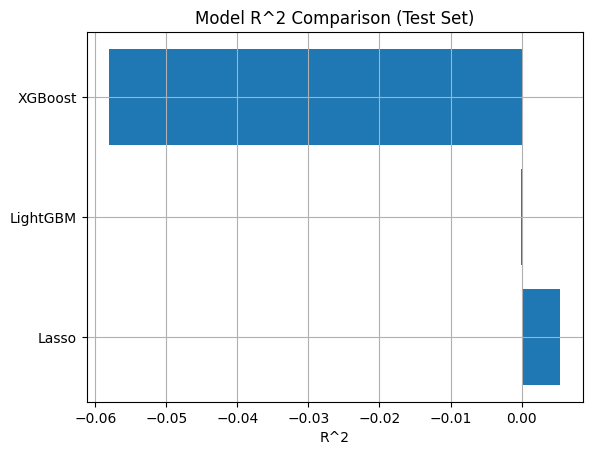

In [49]:
# Compare models on Lasso union features: Lasso, LightGBM, XGBoost

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
factor_vars = list(factor_list["variable"].values)

# Load union features
lasso1 = pd.read_csv("../results/lasso_selected_features.csv", header=None).iloc[1:, 0].tolist()
lassoCV = pd.read_csv("../results/lasso_cv_selected_features.csv", header=None).iloc[1:, 0].tolist()
union_features = list(set(lasso1) | set(lassoCV))
print(f"Using {len(union_features)} features from Lasso union\n")

# Preprocess earning surprise
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize per month [-1, 1]
print("Normalizing features...", flush=True)
all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in union_features:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# 1st expanding window
train = model_df[(model_df["date"] >= "2000-01-01") & (model_df["date"] < "2009-01-01")]
val = model_df[(model_df["date"] >= "2009-01-01") & (model_df["date"] < "2011-01-01")]
test = model_df[(model_df["date"] >= "2011-01-01") & (model_df["date"] < "2012-01-01")]

X_train = train[union_features].values
X_val = val[union_features].values
X_test = test[union_features].values
y_train = train["target_surprise_t+1"].values
y_val = val["target_surprise_t+1"].values
y_test = test["target_surprise_t+1"].values

# Standardize for Lasso
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# === Model 1: Lasso ===
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_std, y_train)
r2_lasso = r2_score(y_test, lasso.predict(X_test_std))
print(f"Lasso R^2: {r2_lasso:.4f}")

# === Model 2: LightGBM ===
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[lgb.early_stopping(20), lgb.log_evaluation(20)])
r2_lgb = r2_score(y_test, lgb_model.predict(X_test))
print(f"LightGBM R^2: {r2_lgb:.4f}")

# === Model 3: XGBoost (no early stopping) ===
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
r2_xgb = r2_score(y_test, xgb_model.predict(X_test))
print(f"XGBoost R^2: {r2_xgb:.4f}")

# Bar plot
plt.barh(["Lasso", "LightGBM", "XGBoost"], [r2_lasso, r2_lgb, r2_xgb])
plt.title("Model R^2 Comparison (Test Set)")
plt.xlabel("R^2")
plt.grid(True)
plt.show()

In [43]:
df1 = pd.read_csv("../results/lasso_cv_selected_features.csv", header=None)
print(df1.head())
print(df1.columns)

                  0
0                 0
1        seas_1_1na
2         saleq_gr1
3          ret_12_1
4  prc_highprc_252d
Index([0], dtype='int64')


In [51]:
# Run expanding-window Lasso prediction (alpha=0.001) for t+1 earning surprise

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tqdm import tqdm

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
lasso_top20 = pd.read_csv("../results/lasso_selected_features.csv", header=None).iloc[1:, 0].tolist()

# Preprocess target
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize [-1, 1] by month
print("Normalizing features...")
all_dates = model_df["date"].unique()
normalized = []
for date in tqdm(all_dates):
    temp = model_df[model_df["date"] == date].copy()
    for var in lasso_top20:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# Expanding window setup
start_year = 2000
test_years = list(range(2011, 2024))  # Run through 2023
results = []
preds = []

print("\nRunning expanding window prediction...\n")
for test_year in tqdm(test_years):
    train = model_df[model_df["date"] < f"{test_year - 2}-01-01"]
    val = model_df[(model_df["date"] >= f"{test_year - 2}-01-01") & (model_df["date"] < f"{test_year}-01-01")]
    test = model_df[(model_df["date"] >= f"{test_year}-01-01") & (model_df["date"] < f"{test_year + 1}-01-01")]

    X_train = train[lasso_top20].values
    y_train = train["target_surprise_t+1"].values
    X_test = test[lasso_top20].values
    y_test = test["target_surprise_t+1"].values

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    lasso = Lasso(alpha=0.001, max_iter=100000)
    lasso.fit(X_train_std, y_train)
    y_pred = lasso.predict(X_test_std)
    r2 = r2_score(y_test, y_pred)

    print(f"Year {test_year}: R^2 = {r2:.4f}")
    results.append({"year": test_year, "r2": r2})

    test_result = test[["date", "permno"]].copy()
    test_result["pred_surprise"] = y_pred
    preds.append(test_result)

Normalizing features...


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [00:06<00:00, 41.85it/s]



Running expanding window prediction...



  8%|██████▍                                                                            | 1/13 [00:00<00:06,  1.84it/s]

Year 2011: R^2 = 0.0055


 15%|████████████▊                                                                      | 2/13 [00:00<00:05,  2.16it/s]

Year 2012: R^2 = -0.0071


 23%|███████████████████▏                                                               | 3/13 [00:01<00:04,  2.40it/s]

Year 2013: R^2 = -0.0143


 31%|█████████████████████████▌                                                         | 4/13 [00:01<00:03,  2.47it/s]

Year 2014: R^2 = -0.0027


 38%|███████████████████████████████▉                                                   | 5/13 [00:02<00:03,  2.46it/s]

Year 2015: R^2 = -0.0048


 46%|██████████████████████████████████████▎                                            | 6/13 [00:02<00:02,  2.39it/s]

Year 2016: R^2 = 0.0007


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:03<00:02,  2.29it/s]

Year 2017: R^2 = -0.0060


 62%|███████████████████████████████████████████████████                                | 8/13 [00:03<00:02,  2.22it/s]

Year 2018: R^2 = -0.0140


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:03<00:01,  2.17it/s]

Year 2019: R^2 = 0.0032


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:04<00:01,  2.07it/s]

Year 2020: R^2 = -0.0579


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:05<00:01,  1.99it/s]

Year 2021: R^2 = -0.1093


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:05<00:00,  1.92it/s]

Year 2022: R^2 = -0.0034


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.11it/s]

Year 2023: R^2 = -0.0075


In [ ]:
# Save prediction results
pred_df = pd.concat(preds).reset_index(drop=True)
pred_df.to_csv("../results/surprise_predictions.csv", index=False)

# Save R^2 log
r2_log = pd.DataFrame(results)
r2_log.to_csv("../results/surprise_r2_log.csv", index=False)
print("\nAll predictions completed. Saved to ../results/surprise_predictions.csv")

In [53]:
# Expanding window with manual alpha tuning (Lasso) using val set

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tqdm import tqdm

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
lasso_top20 = pd.read_csv("../results/lasso_selected_features.csv", header=None).iloc[1:, 0].tolist()

# Preprocess target
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize [-1, 1] by month
print("Normalizing features...")
all_dates = model_df["date"].unique()
normalized = []
for date in tqdm(all_dates):
    temp = model_df[model_df["date"] == date].copy()
    for var in lasso_top20:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# Setup
alphas = 10**np.linspace(-4, -1, 20)
test_years = list(range(2011, 2024))
results = []
preds = []

print("\nRunning expanding window with alpha tuning...\n")
for test_year in tqdm(test_years):
    train = model_df[model_df["date"] < f"{test_year - 2}-01-01"]
    val = model_df[(model_df["date"] >= f"{test_year - 2}-01-01") & (model_df["date"] < f"{test_year}-01-01")]
    test = model_df[(model_df["date"] >= f"{test_year}-01-01") & (model_df["date"] < f"{test_year + 1}-01-01")]

    X_train = train[lasso_top20].values
    y_train = train["target_surprise_t+1"].values
    X_val = val[lasso_top20].values
    y_val = val["target_surprise_t+1"].values
    X_test = test[lasso_top20].values
    y_test = test["target_surprise_t+1"].values

    # Standardize
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)

    # Loop to find best alpha
    best_r2 = -np.inf
    best_alpha = None
    best_model = None
    for a in alphas:
        model = Lasso(alpha=a, max_iter=100000)
        model.fit(X_train_std, y_train)
        r2_val = r2_score(y_val, model.predict(X_val_std))
        if r2_val > best_r2:
            best_r2 = r2_val
            best_alpha = a
            best_model = model

    y_pred = best_model.predict(X_test_std)
    r2_test = r2_score(y_test, y_pred)
    print(f"Year {test_year}: best alpha={best_alpha:.5f}, val R²={best_r2:.4f}, test R²={r2_test:.4f}")
    results.append({"year": test_year, "alpha": best_alpha, "val_r2": best_r2, "test_r2": r2_test})

    test_result = test[["date", "permno"]].copy()
    test_result["pred_surprise"] = y_pred
    preds.append(test_result)

Normalizing features...


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 40.95it/s]



Running expanding window with alpha tuning...



  8%|██████▍                                                                            | 1/13 [00:03<00:41,  3.46s/it]

Year 2011: best alpha=0.01624, val R²=-0.0236, test R²=0.0026


 15%|████████████▊                                                                      | 2/13 [00:06<00:33,  3.02s/it]

Year 2012: best alpha=0.00379, val R²=-0.0030, test R²=-0.0036


 23%|███████████████████▏                                                               | 3/13 [00:09<00:29,  2.94s/it]

Year 2013: best alpha=0.00379, val R²=0.0047, test R²=-0.0093


 31%|█████████████████████████▌                                                         | 4/13 [00:12<00:26,  2.98s/it]

Year 2014: best alpha=0.01624, val R²=-0.0023, test R²=0.0002


 38%|███████████████████████████████▉                                                   | 5/13 [00:15<00:25,  3.14s/it]

Year 2015: best alpha=0.00785, val R²=-0.0013, test R²=-0.0007


 46%|██████████████████████████████████████▎                                            | 6/13 [00:19<00:22,  3.29s/it]

Year 2016: best alpha=0.00785, val R²=0.0015, test R²=-0.0009


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:22<00:20,  3.36s/it]

Year 2017: best alpha=0.00379, val R²=0.0017, test R²=-0.0051


 62%|███████████████████████████████████████████████████                                | 8/13 [00:26<00:17,  3.47s/it]

Year 2018: best alpha=0.00264, val R²=0.0007, test R²=-0.0137


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:30<00:14,  3.59s/it]

Year 2019: best alpha=0.00183, val R²=-0.0066, test R²=0.0037


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:34<00:11,  3.82s/it]

Year 2020: best alpha=0.00183, val R²=-0.0002, test R²=-0.0581


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:38<00:07,  3.83s/it]

Year 2021: best alpha=0.00010, val R²=-0.0214, test R²=-0.1076


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:42<00:03,  3.86s/it]

Year 2022: best alpha=0.00010, val R²=-0.0760, test R²=-0.0028


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:46<00:00,  3.56s/it]

Year 2023: best alpha=0.00010, val R²=-0.0312, test R²=-0.0061


In [ ]:
# Save
pred_df = pd.concat(preds).reset_index(drop=True)
pred_df.to_csv("../results/surprise_predictions.csv", index=False)
r2_df = pd.DataFrame(results)
r2_df.to_csv("../results/surprise_r2_log.csv", index=False)
print("\nAll predictions saved to ../results/surprise_predictions.csv")

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
lasso_top20 = pd.read_csv("../results/lasso_selected_features.csv", header=None).iloc[1:, 0].tolist()

firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

all_dates = model_df["date"].unique()
normalized = []
for date in all_dates:
    temp = model_df[model_df["date"] == date].copy()
    for var in lasso_top20:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

alphas = 10**np.linspace(-4, -1, 20)
test_year = 2010

train = model_df[model_df["date"] < "2008-01-01"]
val = model_df[(model_df["date"] >= "2008-01-01") & (model_df["date"] < "2010-01-01")]
test = model_df[(model_df["date"] >= "2010-01-01") & (model_df["date"] < "2011-01-01")]

X_train_feat = train[lasso_top20].values
y_train = train["target_surprise_t+1"].values
scaler_feat = StandardScaler()
X_train_std = scaler_feat.fit_transform(X_train_feat)
selector_model = Lasso(alpha=0.001, max_iter=100000)
selector_model.fit(X_train_std, y_train)
selected_features = [lasso_top20[i] for i, keep in enumerate(selector_model.coef_ != 0) if keep]

X_train = train[selected_features].values
y_train = train["target_surprise_t+1"].values
X_val = val[selected_features].values
y_val = val["target_surprise_t+1"].values
X_test = test[selected_features].values
y_test = test["target_surprise_t+1"].values

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

best_r2 = -np.inf
best_alpha = None
best_model = None
for a in alphas:
    model = Lasso(alpha=a, max_iter=100000)
    model.fit(X_train_std, y_train)
    r2_val = r2_score(y_val, model.predict(X_val_std))
    if r2_val > best_r2:
        best_r2 = r2_val
        best_alpha = a
        best_model = model

# Final model on train + val
combined = pd.concat([train, val])
X_combined = combined[selected_features].values
y_combined = combined["target_surprise_t+1"].values
X_test_final = test[selected_features].values

scaler_final = StandardScaler()
X_combined_std = scaler_final.fit_transform(X_combined)
X_test_std = scaler_final.transform(X_test_final)

final_model = Lasso(alpha=best_alpha, max_iter=100000)
final_model.fit(X_combined_std, y_combined)
y_pred = final_model.predict(X_test_std)
r2_test = r2_score(y_test, y_pred)

print(f"Year {test_year}: best alpha={best_alpha:.5f}, val R²={best_r2:.4f}, test R²={r2_test:.4f}, selected={len(selected_features)}")

test_result_2010 = test[["date", "permno"]].copy()
test_result_2010["pred_surprise"] = y_pred

Year 2010: best alpha=0.00010, val R²=0.0249, test R²=-0.0290, selected=17


In [2]:
test_result_2010.to_csv("../results/surprise_2010.csv", index=False)

In [57]:
# Expanding window with per-round feature selection using fixed alpha, then tuning alpha

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tqdm import tqdm

# Load data
firm_df = pd.read_csv("../data/raw/mma_sample_v2.csv", parse_dates=["date"])
factor_list = pd.read_csv("../data/raw/factor_char_list.csv")
lasso_top20 = pd.read_csv("../results/lasso_selected_features.csv", header=None).iloc[1:, 0].tolist()

# Preprocess target
firm_df = firm_df.dropna(subset=["eps_meanest", "eps_actual"])
firm_df = firm_df.sort_values(["permno", "date"])
firm_df["earning_surprise"] = firm_df["eps_actual"] - firm_df["eps_meanest"]
firm_df["earning_surprise"] = firm_df["earning_surprise"].clip(
    lower=firm_df["earning_surprise"].quantile(0.01),
    upper=firm_df["earning_surprise"].quantile(0.99))
firm_df["target_surprise_t+1"] = firm_df.groupby("permno")["earning_surprise"].shift(-1)
model_df = firm_df.dropna(subset=["target_surprise_t+1"]).copy()

# Normalize [-1, 1] by month
print("Normalizing features...")
all_dates = model_df["date"].unique()
normalized = []
for date in tqdm(all_dates):
    temp = model_df[model_df["date"] == date].copy()
    for var in lasso_top20:
        median = temp[var].median()
        temp[var] = temp[var].fillna(median)
        temp[var] = temp[var].rank(method="dense") - 1
        max_val = temp[var].max()
        temp[var] = (temp[var] / max_val) * 2 - 1 if max_val > 0 else 0
    normalized.append(temp)
model_df = pd.concat(normalized).reset_index(drop=True)

# Setup
alphas = 10**np.linspace(-4, -1, 20)
test_years = list(range(2011, 2024))
results = []
preds = []
feature_logs = []

print("\nRunning expanding window with fixed-alpha feature selection and tuned-alpha prediction...\n")
for test_year in tqdm(test_years):
    train = model_df[model_df["date"] < f"{test_year - 2}-01-01"]
    val = model_df[(model_df["date"] >= f"{test_year - 2}-01-01") & (model_df["date"] < f"{test_year}-01-01")]
    test = model_df[(model_df["date"] >= f"{test_year}-01-01") & (model_df["date"] < f"{test_year + 1}-01-01")]

    # Step 1: use fixed alpha=0.001 to select features
    X_train_feat = train[lasso_top20].values
    y_train = train["target_surprise_t+1"].values
    scaler_feat = StandardScaler()
    X_train_std = scaler_feat.fit_transform(X_train_feat)
    selector_model = Lasso(alpha=0.001, max_iter=100000)
    selector_model.fit(X_train_std, y_train)
    selected_features = [lasso_top20[i] for i, keep in enumerate(selector_model.coef_ != 0) if keep]
    feature_logs.append({"year": test_year, "selected_features": selected_features})

    # Step 2: tune alpha using selected features
    X_train = train[selected_features].values
    y_train = train["target_surprise_t+1"].values
    X_val = val[selected_features].values
    y_val = val["target_surprise_t+1"].values
    X_test = test[selected_features].values
    y_test = test["target_surprise_t+1"].values

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)

    best_r2 = -np.inf
    best_alpha = None
    best_model = None
    for a in alphas:
        model = Lasso(alpha=a, max_iter=100000)
        model.fit(X_train_std, y_train)
        r2_val = r2_score(y_val, model.predict(X_val_std))
        if r2_val > best_r2:
            best_r2 = r2_val
            best_alpha = a
            best_model = model

    # Final model trained on train+val
    combined = pd.concat([train, val])
    X_combined = combined[selected_features].values
    y_combined = combined["target_surprise_t+1"].values
    X_test_final = test[selected_features].values

    scaler_final = StandardScaler()
    X_combined_std = scaler_final.fit_transform(X_combined)
    X_test_std = scaler_final.transform(X_test_final)

    final_model = Lasso(alpha=best_alpha, max_iter=100000)
    final_model.fit(X_combined_std, y_combined)
    y_pred = final_model.predict(X_test_std)
    r2_test = r2_score(y_test, y_pred)

    print(f"Year {test_year}: best alpha={best_alpha:.5f}, val R²={best_r2:.4f}, test R²={r2_test:.4f}, selected={len(selected_features)}")
    results.append({"year": test_year, "alpha": best_alpha, "val_r2": best_r2, "test_r2": r2_test})

    test_result = test[["date", "permno"]].copy()
    test_result["pred_surprise"] = y_pred
    preds.append(test_result)

Normalizing features...


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 39.61it/s]



Running expanding window with fixed-alpha feature selection and tuned-alpha prediction...



  8%|██████▍                                                                            | 1/13 [00:03<00:45,  3.81s/it]

Year 2011: best alpha=0.01624, val R²=-0.0236, test R²=0.0041, selected=19


 15%|████████████▊                                                                      | 2/13 [00:06<00:37,  3.41s/it]

Year 2012: best alpha=0.00379, val R²=-0.0028, test R²=-0.0002, selected=17


 23%|███████████████████▏                                                               | 3/13 [00:09<00:31,  3.18s/it]

Year 2013: best alpha=0.00379, val R²=0.0048, test R²=-0.0069, selected=15


 31%|█████████████████████████▌                                                         | 4/13 [00:12<00:27,  3.10s/it]

Year 2014: best alpha=0.01624, val R²=-0.0023, test R²=0.0004, selected=15


 38%|███████████████████████████████▉                                                   | 5/13 [00:15<00:24,  3.10s/it]

Year 2015: best alpha=0.00785, val R²=-0.0013, test R²=0.0009, selected=15


 46%|██████████████████████████████████████▎                                            | 6/13 [00:19<00:22,  3.21s/it]

Year 2016: best alpha=0.00785, val R²=0.0015, test R²=0.0002, selected=15


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:23<00:20,  3.41s/it]

Year 2017: best alpha=0.00379, val R²=0.0018, test R²=-0.0031, selected=15


 62%|███████████████████████████████████████████████████                                | 8/13 [00:26<00:17,  3.48s/it]

Year 2018: best alpha=0.00264, val R²=0.0007, test R²=-0.0094, selected=15


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:30<00:14,  3.60s/it]

Year 2019: best alpha=0.00264, val R²=-0.0066, test R²=0.0077, selected=16


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:34<00:11,  3.73s/it]

Year 2020: best alpha=0.00264, val R²=-0.0002, test R²=-0.0536, selected=16


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:39<00:07,  3.96s/it]

Year 2021: best alpha=0.00010, val R²=-0.0211, test R²=-0.0881, selected=16


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:43<00:04,  4.04s/it]

Year 2022: best alpha=0.00010, val R²=-0.0760, test R²=0.0116, selected=16


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:47<00:00,  3.62s/it]

Year 2023: best alpha=0.00010, val R²=-0.0311, test R²=0.0061, selected=15


In [58]:
# Save
pred_df = pd.concat(preds).reset_index(drop=True)
pred_df.to_csv("../results/surprise_predictions.csv", index=False)
r2_df = pd.DataFrame(results)
r2_df.to_csv("../results/surprise_r2_log.csv", index=False)
pd.DataFrame(feature_logs).to_json("../results/surprise_feature_logs.json", orient="records", lines=True)
print("\nAll predictions and selected features saved.")


All predictions and selected features saved.


In [3]:
# Load existing surprise predictions
old_surprise = pd.read_csv("../results/surprise_predictions.csv", parse_dates=["date"])

# Ensure both DataFrames have the same columns
test_result_2010 = test_result_2010[["date", "permno", "pred_surprise"]]
old_surprise = old_surprise[["date", "permno", "pred_surprise"]]

# Combine the new 2010 predictions with the existing data
updated_surprise = pd.concat([test_result_2010, old_surprise], ignore_index=True)

# Drop duplicates by permno + date, keeping the first occurrence (i.e., the new 2010 ones)
updated_surprise = updated_surprise.drop_duplicates(subset=["permno", "date"], keep="first")

# Sort the result by date ascending
updated_surprise = updated_surprise.sort_values("date").reset_index(drop=True)

# Save the final combined surprise prediction file
updated_surprise.to_csv("../results/surprise_predictions_updated.csv", index=False)